# Multi-Batch Slope Classification Pipeline

  
**Version**: 3.0 - Multi-Batch Implementation

## Environment Setup and Configuration


In [ ]:
# Environment setup for Google Colab
from google.colab import drive
drive.mount('/content/drive')
BASE_PATH = '/content/drive/MyDrive/msc proj- data/June_3_25/'
print(f"Environment setup complete. Base path: {BASE_PATH}")

Mounted at /content/drive
Environment setup complete. Base path: /content/drive/MyDrive/msc proj- data/June_3_25/


In [ ]:
# Core libraries for data processing
import cv2
import pandas as pd
import numpy as np
import os
import warnings
from collections import Counter
from datetime import datetime

# Machine learning libraries
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix,
                           ConfusionMatrixDisplay, accuracy_score, f1_score)

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

All libraries imported successfully!
TensorFlow version: 2.19.0


In [ ]:
# Project configuration for multi-batch slope classification processing
CONFIG = {
    # Input and output paths
    'BASE_DATA_PATH': '/content/drive/MyDrive/msc proj- data/June_3_25/Video_Telometry/',
    'BASE_OUTPUT_DIR': '/content/drive/MyDrive/msc proj- data/June_3_25/Preprocessed_All_Rides',
    'OUTPUT_DIR': '/content/drive/MyDrive/msc proj- data/June_3_25/Model_Output',

    # Model hyperparameters
    'IMG_SIZE': (224, 224),
    'BATCH_SIZE': 32,
    'EPOCHS': 30,
    'LEARNING_RATE': 1e-3,
    'DROPOUT_RATE': 0.3,
    'PATIENCE': 5,

    # Data processing parameters
    'FRAME_SKIP': 10,
    'VALIDATION_SPLIT': 0.2,
    'MAX_SAMPLES_PER_CLASS': 500,
    'RANDOM_STATE': 42,

    # Multi-batch processing parameters
    'SKIP_FOLDERS': ['C'],  # Fixed naming consistency
    'EXPECTED_EXTENSIONS': {'.mp4', '.xlsx'},
    'PROGRESS_INTERVAL': 100,

    # Data Augmentation parameters (HIGH-CONFIDENCE TERRAIN CLASSIFICATION AUGMENTATIONS)
    'USE_AUGMENTATION': True,  # Enable/disable augmentation
    'AUG_HORIZONTAL_FLIP': True,  # Proven effective for road scenes
    'AUG_ROTATION_RANGE': 8,  # Conservative rotation (±8°) - preserves slope geometry
    'AUG_BRIGHTNESS_RANGE': 0.2,  # ±20% brightness - handles lighting variations
    'AUG_CONTRAST_RANGE': (0.9, 1.1),  # Subtle contrast changes
    'AUG_SATURATION_RANGE': (0.85, 1.15),  # Color saturation for weather robustness
    'AUG_NOISE_FACTOR': 0.01,  # Gaussian noise for sensor noise simulation
    'AUG_ZOOM_RANGE': 0.05,  # ±5% zoom - minimal geometric distortion
}

# Create base output directories
os.makedirs(CONFIG['BASE_OUTPUT_DIR'], exist_ok=True)
os.makedirs(CONFIG['OUTPUT_DIR'], exist_ok=True)  # Added OUTPUT_DIR creation

print(f"Configuration loaded successfully")
print(f"Base data path: {CONFIG['BASE_DATA_PATH']}")
print(f"Output directory: {CONFIG['BASE_OUTPUT_DIR']}")
print(f"Model output directory: {CONFIG['OUTPUT_DIR']}")
print(f"Excluded folders: {CONFIG['SKIP_FOLDERS']}")
print(f"Data Augmentation: {' ENABLED' if CONFIG['USE_AUGMENTATION'] else ' DISABLED'}")
if CONFIG['USE_AUGMENTATION']:
    print(f"  • Horizontal Flip: {CONFIG['AUG_HORIZONTAL_FLIP']}")
    print(f"  • Rotation Range: ±{CONFIG['AUG_ROTATION_RANGE']}°")
    print(f"  • Brightness Range: ±{int(CONFIG['AUG_BRIGHTNESS_RANGE']*100)}%")
    print(f"  • Contrast Range: {CONFIG['AUG_CONTRAST_RANGE']}")
    print(f"  • Saturation Range: {CONFIG['AUG_SATURATION_RANGE']}")
    print(f"  • Noise Factor: {CONFIG['AUG_NOISE_FACTOR']}")
    print(f"  • Zoom Range: ±{int(CONFIG['AUG_ZOOM_RANGE']*100)}%")

Configuration loaded successfully
Base data path: /content/drive/MyDrive/msc proj- data/June_3_25/Video_Telometry/
Output directory: /content/drive/MyDrive/msc proj- data/June_3_25/Preprocessed_All_Rides
Model output directory: /content/drive/MyDrive/msc proj- data/June_3_25/Model_Output
Excluded folders: ['C']
Data Augmentation:  ENABLED
  • Horizontal Flip: True
  • Rotation Range: ±8°
  • Brightness Range: ±20%
  • Contrast Range: (0.9, 1.1)
  • Saturation Range: (0.85, 1.15)
  • Noise Factor: 0.01
  • Zoom Range: ±5%


## Core Processing Functions

 Essential functions for data preprocessing, feature extraction, and dataset creation.

In [ ]:
def load_and_clean_telemetry(file_path):
    """
    Load telemetry data from Excel or CSV file and perform initial cleaning.

    Args:
        file_path (str): Path to the Excel (.xlsx) or CSV (.csv) file containing telemetry data

    Returns:
        pd.DataFrame: Cleaned telemetry dataframe with valid AngleY values
    """
    try:
        # Determine file type and load accordingly
        file_extension = os.path.splitext(file_path)[1].lower()

        if file_extension == '.xlsx':
            # Load Excel file
            df = pd.read_excel(file_path)
            print(f"Loaded Excel telemetry file: {file_path}")
        elif file_extension == '.csv':
            # Load CSV file
            df = pd.read_csv(file_path)
            print(f"Loaded CSV telemetry file: {file_path}")
        else:
            raise ValueError(f"Unsupported file format: {file_extension}. Expected .xlsx or .csv")

        # Clean: keep only rows with valid AngleY values
        angle_column = 'AngleY(°)'

        # Check if the angle column exists
        if angle_column not in df.columns:
            # Try alternative column names
            possible_columns = [col for col in df.columns if 'angle' in col.lower() and 'y' in col.lower()]
            if possible_columns:
                angle_column = possible_columns[0]
                print(f"Using column '{angle_column}' for angle data")
            else:
                raise ValueError(f"Could not find angle column. Available columns: {list(df.columns)}")

        initial_count = len(df)
        df = df.dropna(subset=[angle_column])
        cleaned_count = len(df)

        print(f"Loaded telemetry data: {df.shape}")
        print(f"Removed {initial_count - cleaned_count} rows with missing angle values")

        # Ensure the standard column name for consistency
        if angle_column != 'AngleY(°)':
            df = df.rename(columns={angle_column: 'AngleY(°)'})
            print(f"Renamed column '{angle_column}' to 'AngleY(°)' for consistency")

        return df

    except Exception as e:
        print(f"Error loading telemetry data from {file_path}: {e}")
        raise

In [ ]:
def assign_slope_label(angle):
    """
    Assign slope labels based on angle thresholds.

    Args:
        angle (float): Angle in degrees

    Returns:
        str: Slope label ('flat', 'low_uphill', 'low_downhill', 'high_uphill', 'high_downhill')
             or None if input is invalid
    """
    try:
        angle = float(angle)
        if pd.isna(angle):
            return None

        # Define slope categories based on angle ranges
        if -2 <= angle <= 2:
            return 'flat'
        elif 2 < angle <= 6:
            return 'low_uphill'
        elif -6 <= angle < -2:
            return 'low_downhill'
        elif angle > 6:
            return 'high_uphill'
        else:  # angle < -6
            return 'high_downhill'

    except (ValueError, TypeError):
        return None

In [ ]:
def analyze_video_metadata(video_path):
    """
    Extract metadata from video file.

    Args:
        video_path (str): Path to video file

    Returns:
        dict: Video metadata including fps, frame_count, width, height, duration
    """
    try:
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            raise ValueError(f"Could not open video file: {video_path}")

        # Extract video properties
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        video_duration = frame_count / fps if fps > 0 else 0

        cap.release()

        metadata = {
            'fps': fps,
            'frame_count': frame_count,
            'width': width,
            'height': height,
            'duration': video_duration
        }

        print(f"Video metadata: {width}x{height}, {fps:.1f}fps, {frame_count:,} frames, {video_duration:.1f}s")
        return metadata

    except Exception as e:
        print(f"Error analyzing video: {e}")
        raise

In [ ]:
def extract_frames_with_labels(video_path, telemetry_df, output_dir, frame_skip=10, progress_interval=100):
    """
    Extract frames from video and associate with telemetry labels.

    Args:
        video_path (str): Path to video file
        telemetry_df (pd.DataFrame): Telemetry dataframe with slope labels
        output_dir (str): Directory to save extracted frames
        frame_skip (int): Skip interval for frame extraction
        progress_interval (int): Print progress every N frames

    Returns:
        list: List of frame metadata dictionaries
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    frame_labels = []
    extracted_count = 0
    failed_count = 0

    try:
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            raise ValueError(f"Could not open video: {video_path}")

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        telemetry_samples = len(telemetry_df)
        telemetry_per_frame = telemetry_samples / total_frames

        print(f"Extracting every {frame_skip}th frame from {total_frames:,} total frames")

        for frame_idx in range(0, total_frames, frame_skip):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()

            if not ret:
                failed_count += 1
                continue

            # Calculate corresponding telemetry index
            telemetry_idx = int(frame_idx * telemetry_per_frame)
            telemetry_idx = min(telemetry_idx, len(telemetry_df) - 1)

            # Get angle and label from telemetry
            angle = telemetry_df.iloc[telemetry_idx]['AngleY(°)']
            label = telemetry_df.iloc[telemetry_idx]['slope_label']

            # Create filename and save frame
            frame_name = f"frame_{frame_idx:05d}_{label}_{angle:.2f}.jpg"
            frame_path = os.path.join(output_dir, frame_name)

            if cv2.imwrite(frame_path, frame):
                frame_labels.append({
                    'frame_path': frame_path,
                    'frame_index': frame_idx,
                    'telemetry_index': telemetry_idx,
                    'angle': angle,
                    'label': label,
                    'filename': frame_name
                })
                extracted_count += 1

                if extracted_count % progress_interval == 0:
                    print(f"Extracted {extracted_count} frames")
            else:
                failed_count += 1

        cap.release()

        print(f"Frame extraction complete: {extracted_count} successful, {failed_count} failed")
        return frame_labels

    except Exception as e:
        print(f"Error during frame extraction: {e}")
        if 'cap' in locals():
            cap.release()
        raise

In [ ]:
def create_balanced_dataset(frame_labels, output_dir, max_samples_per_class=500):
    """
    Create and save dataset with proper balancing using minimum sample strategy.
    All classes will have the same number of samples (equal to the smallest class).

    Args:
        frame_labels (list): List of frame metadata dictionaries
        output_dir (str): Output directory for CSV files
        max_samples_per_class (int): Maximum samples per class (used as upper limit)

    Returns:
        tuple: (full_df, balanced_df) - Full and balanced DataFrames
    """
    if not frame_labels:
        raise ValueError("No frames extracted - cannot create dataset")

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Create full dataset DataFrame
    labels_df = pd.DataFrame(frame_labels)

    # Display class distribution
    class_counts = labels_df['label'].value_counts()
    print(f"Full dataset: {len(labels_df):,} samples")
    for label, count in class_counts.items():
        percentage = (count / len(labels_df)) * 100
        print(f"  {label}: {count:,} samples ({percentage:.1f}%)")

    # Save full dataset
    full_csv_path = os.path.join(output_dir, 'labels.csv')
    labels_df.to_csv(full_csv_path, index=False)

    # FIXED: Use minimum sample strategy for true balancing
    min_samples = min(class_counts)

    # Apply max_samples_per_class as an upper limit
    target_samples = min(max_samples_per_class, min_samples)

    print(f"\nBalancing Strategy:")
    print(f"  Minimum class size: {min_samples}")
    print(f"  Max samples per class limit: {max_samples_per_class}")
    print(f"  Target samples per class: {target_samples}")

    balanced_samples = []

    for label in class_counts.index:
        class_samples = labels_df[labels_df['label'] == label]

        # Always sample exactly target_samples for true balancing
        if len(class_samples) >= target_samples:
            class_samples = class_samples.sample(
                n=target_samples,
                random_state=CONFIG['RANDOM_STATE']
            )
            print(f"  {label}: Sampled {target_samples} from {len(labels_df[labels_df['label'] == label])} available")
        else:
            # This shouldn't happen since target_samples = min(class sizes)
            print(f"  {label}: Using all {len(class_samples)} samples (less than target)")

        balanced_samples.append(class_samples)

    # Combine all balanced samples
    balanced_df = pd.concat(balanced_samples, ignore_index=True)

    # Shuffle the balanced dataset
    balanced_df = balanced_df.sample(frac=1, random_state=CONFIG['RANDOM_STATE']).reset_index(drop=True)

    # Save balanced dataset
    balanced_csv_path = os.path.join(output_dir, 'labels_balanced.csv')
    balanced_df.to_csv(balanced_csv_path, index=False)

    print(f"\nBalanced dataset created: {len(balanced_df):,} samples")

    # Verify perfect balancing
    balanced_counts = balanced_df['label'].value_counts().sort_index()
    print(f"Balanced distribution (should all be {target_samples}):")
    all_equal = True
    for label, count in balanced_counts.items():
        print(f"  {label}: {count} samples")
        if count != target_samples:
            all_equal = False

    if all_equal:
        print("Perfect balance achieved - all classes have equal samples!")
    else:
        print("Balance verification failed - class counts are not equal")

    return labels_df, balanced_df

## Visualization Functions

This section defines functions for creating comprehensive visualizations and analysis of the processed datasets.

In [ ]:
def create_comprehensive_visualizations(df_full, df_balanced, output_dir):
    """
    Create comprehensive visualizations for dataset analysis.

    Args:
        df_full (pd.DataFrame): Full dataset
        df_balanced (pd.DataFrame): Balanced dataset
        output_dir (str): Directory to save visualizations

    Returns:
        matplotlib.figure.Figure: Generated figure object
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Get class counts
    full_counts = df_full['label'].value_counts()
    balanced_counts = df_balanced['label'].value_counts()

    # Create figure with subplots
    fig = plt.figure(figsize=(16, 12))

    # Color palette for consistency
    colors = plt.cm.Set3(np.linspace(0, 1, len(balanced_counts)))

    # Plot 1: Class distribution comparison
    plt.subplot(2, 3, 1)
    x = range(len(full_counts))
    width = 0.35
    plt.bar([i - width/2 for i in x], full_counts.values, width,
            label='Full Dataset', alpha=0.8, color='skyblue')
    plt.bar([i + width/2 for i in x], [balanced_counts.get(label, 0) for label in full_counts.index],
            width, label='Balanced Dataset', alpha=0.8, color='lightcoral')
    plt.xticks(x, full_counts.index, rotation=45, ha='right')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Angle distribution histogram
    plt.subplot(2, 3, 2)
    plt.hist(df_full['angle'], bins=50, alpha=0.7, color='skyblue', edgecolor='black', density=True)
    plt.xlabel('Angle (degrees)')
    plt.ylabel('Density')
    plt.title('Angle Distribution')
    plt.grid(True, alpha=0.3)

    # Plot 3: Angle by class boxplot
    plt.subplot(2, 3, 3)
    box_data = [df_full[df_full['label'] == label]['angle'] for label in df_full['label'].unique()]
    box_plot = plt.boxplot(box_data, labels=df_full['label'].unique(), patch_artist=True)
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Angle (degrees)')
    plt.title('Angle Distribution by Class')
    plt.grid(True, alpha=0.3)

    # Plot 4: Balanced dataset pie chart
    plt.subplot(2, 3, 4)
    plt.pie(balanced_counts.values, labels=balanced_counts.index, autopct='%1.1f%%', colors=colors)
    plt.title('Balanced Dataset Distribution')

    # Plot 5: Sample counts
    plt.subplot(2, 3, 5)
    datasets = ['Full', 'Balanced']
    counts = [len(df_full), len(df_balanced)]
    plt.bar(datasets, counts, color=['skyblue', 'lightcoral'], alpha=0.8)
    plt.ylabel('Number of Samples')
    plt.title('Dataset Size Comparison')
    for i, count in enumerate(counts):
        plt.text(i, count + max(counts)*0.01, f'{count:,}', ha='center', va='bottom')

    plt.tight_layout()

    # Save visualization
    viz_path = os.path.join(output_dir, 'dataset_analysis.png')
    plt.savefig(viz_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.close()

    print(f"Visualizations saved to: {viz_path}")
    return fig

## Multi-Batch Processing Pipeline

This section implements the main batch processing pipeline that discovers ride folders, processes each ride through the complete preprocessing pipeline, and creates master datasets.

In [ ]:
def discover_ride_directories(base_path, exclude_folders=None):
    """
    Discover all ride directories in the base path.

    Args:
        base_path (str): Base directory path
        exclude_folders (list): List of folder names to exclude

    Returns:
        list: List of ride directory names
    """
    if exclude_folders is None:
        exclude_folders = []

    try:
        all_items = os.listdir(base_path)
        ride_dirs = []

        for item in all_items:
            item_path = os.path.join(base_path, item)
            if os.path.isdir(item_path) and item not in exclude_folders:
                ride_dirs.append(item)

        ride_dirs.sort()
        print(f"Discovered {len(ride_dirs)} ride directories: {ride_dirs}")
        return ride_dirs

    except Exception as e:
        print(f"Error discovering ride directories: {e}")
        return []

In [ ]:
def process_all_rides_batch():
    """
    Process all rides in batch mode to create comprehensive datasets.
    Processes all ride directories except excluded ones and creates master datasets.
    """
    print("=" * 80)
    print("BATCH PROCESSING: Processing All Rides")
    print("=" * 80)

    # Discover all ride directories
    ride_dirs = discover_ride_directories(CONFIG['BASE_DATA_PATH'], CONFIG['SKIP_FOLDERS'])

    if not ride_dirs:
        print("No ride directories found. Exiting.")
        return

    # Create output directory
    os.makedirs(CONFIG['BASE_OUTPUT_DIR'], exist_ok=True)

    all_data = []
    processing_summary = []

    # Process each ride
    for i, ride_name in enumerate(ride_dirs, 1):
        print(f"\n[{i}/{len(ride_dirs)}] Processing ride: {ride_name}")
        print("-" * 60)

        try:
            # Set paths for current ride
            ride_base_path = os.path.join(CONFIG['BASE_DATA_PATH'], ride_name)
            output_path = os.path.join(CONFIG['BASE_OUTPUT_DIR'], ride_name)
            frames_dir = os.path.join(output_path, 'frames')

            # FLEXIBLE FILE DISCOVERY
            all_files = os.listdir(ride_base_path)

            # Find telemetry file
            telemetry_file = None
            for file in all_files:
                if file.endswith(('.xlsx', '.csv')):
                    telemetry_file = os.path.join(ride_base_path, file)
                    print(f"✅ Found telemetry: {file}")
                    break

            # Find video file (any .mp4 or .MP4)
            video_file = None
            for file in all_files:
                if file.endswith(('.mp4', '.MP4', '.avi', '.mov')):
                    video_file = os.path.join(ride_base_path, file)
                    print(f"✅ Found video: {file}")
                    break

            # Check if required files exist
            if not telemetry_file:
                print(f"Warning: Telemetry file not found for {ride_name}")
                processing_summary.append(f"{ride_name}: Missing telemetry file")
                continue

            if not video_file:
                print(f"Warning: Video file not found for {ride_name}")
                processing_summary.append(f"{ride_name}: Missing video file")
                continue

            # Create output directories
            os.makedirs(output_path, exist_ok=True)
            os.makedirs(frames_dir, exist_ok=True)

            # Load and process telemetry data
            print("Loading and cleaning telemetry data...")
            telemetry_data = load_and_clean_telemetry(telemetry_file)

            if telemetry_data is not None and not telemetry_data.empty:
                # Assign slope labels
                telemetry_data['slope_label'] = telemetry_data['AngleY(°)'].apply(assign_slope_label)

                # Extract frames with labels
                print("Extracting frames and labels...")
                frame_labels = extract_frames_with_labels(
                    video_file,
                    telemetry_data,
                    frames_dir,
                    frame_skip=CONFIG['FRAME_SKIP'],
                    progress_interval=CONFIG['PROGRESS_INTERVAL']
                )

                if frame_labels and len(frame_labels) > 0:
                    # Create dataset DataFrames
                    labels_df, balanced_df = create_balanced_dataset(
                        frame_labels,
                        output_path,
                        max_samples_per_class=CONFIG['MAX_SAMPLES_PER_CLASS']
                    )

                    # Add ride identifier
                    labels_df['ride_name'] = ride_name
                    balanced_df['ride_name'] = ride_name

                    all_data.append(balanced_df)
                    processing_summary.append(f"{ride_name}: Successfully processed ({len(labels_df)} total, {len(balanced_df)} balanced)")
                    print(f"Successfully processed {len(labels_df)} total samples ({len(balanced_df)} balanced) for {ride_name}")
                else:
                    processing_summary.append(f"{ride_name}: No valid samples extracted")
                    print(f"No valid samples extracted for {ride_name}")
            else:
                processing_summary.append(f"{ride_name}: Invalid telemetry data")
                print(f"Invalid telemetry data for {ride_name}")

        except Exception as e:
            error_msg = f"{ride_name}: Error - {str(e)}"
            processing_summary.append(error_msg)
            print(f"Error processing {ride_name}: {e}")

    # Create master datasets if we have data
    if all_data:
        print("\n" + "=" * 60)
        print("Creating Master Datasets")
        print("=" * 60)

        # Combine all data
        combined_df = pd.concat(all_data, ignore_index=True)

        # Save master balanced dataset
        balanced_output_path = os.path.join(CONFIG['BASE_OUTPUT_DIR'], 'ALL_RIDES_labels_balanced.csv')
        combined_df.to_csv(balanced_output_path, index=False)
        print(f"Master balanced dataset saved: {balanced_output_path}")
        print(f"Total master samples: {len(combined_df)}")

        # Store in global variable for ML pipeline
        global master_balanced_df
        master_balanced_df = combined_df

        # Create comprehensive visualizations
        print("\nCreating comprehensive visualizations...")
        create_comprehensive_visualizations(combined_df, combined_df, CONFIG['BASE_OUTPUT_DIR'])

        # Save processing report
        report_path = os.path.join(CONFIG['BASE_OUTPUT_DIR'], 'MULTI_RIDE_PROCESSING_REPORT.txt')
        with open(report_path, 'w') as f:
            f.write("MULTI-RIDE PROCESSING REPORT\n")
            f.write("=" * 50 + "\n\n")
            f.write(f"Processing Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"Total Rides Processed: {len(all_data)}\n")
            f.write(f"Master Dataset Size: {len(combined_df)}\n\n")
            f.write("Per-Ride Summary:\n")
            f.write("-" * 30 + "\n")
            for summary in processing_summary:
                f.write(f"{summary}\n")
        print(f"Processing report saved: {report_path}")

    # Print final summary
    print("\n" + "=" * 80)
    print("BATCH PROCESSING COMPLETE - SUMMARY")
    print("=" * 80)
    for summary in processing_summary:
        print(f"  {summary}")
    print("=" * 80)

In [ ]:
# Execute batch processing for all rides
process_all_rides_batch()

BATCH PROCESSING: Processing All Rides
Discovered 13 ride directories: ['A', 'B', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N']

[1/13] Processing ride: A
------------------------------------------------------------
✅ Found telemetry: GH010161.xlsx
✅ Found video: GH010161.MP4
Loading and cleaning telemetry data...
Loaded Excel telemetry file: /content/drive/MyDrive/msc proj- data/June_3_25/Video_Telometry/A/GH010161.xlsx
Loaded telemetry data: (23936, 21)
Removed 0 rows with missing angle values
Extracting frames and labels...
Extracting every 10th frame from 14,015 total frames
Extracted 100 frames
Extracted 200 frames
Extracted 300 frames
Extracted 400 frames
Extracted 500 frames
Extracted 600 frames
Extracted 700 frames
Extracted 800 frames
Extracted 900 frames
Extracted 1000 frames
Extracted 1100 frames
Extracted 1200 frames
Extracted 1300 frames
Frame extraction complete: 1399 successful, 3 failed
Full dataset: 1,399 samples
  flat: 627 samples (44.8%)
  low_uphill: 268 s

## Pre-Training Dataset Visualization

This section provides comprehensive visualizations of the compiled master dataset to confirm proper data preparation before model training.

 LOADING AND ANALYZING COMPILED DATASETS
 Loading datasets...
Balanced dataset loaded: 4,934 samples
 Full dataset compiled: 17,441 samples from 13 rides

💾 Visualization saved to: /content/drive/MyDrive/msc proj- data/June_3_25/Model_Output/pre_training_dataset_analysis.png


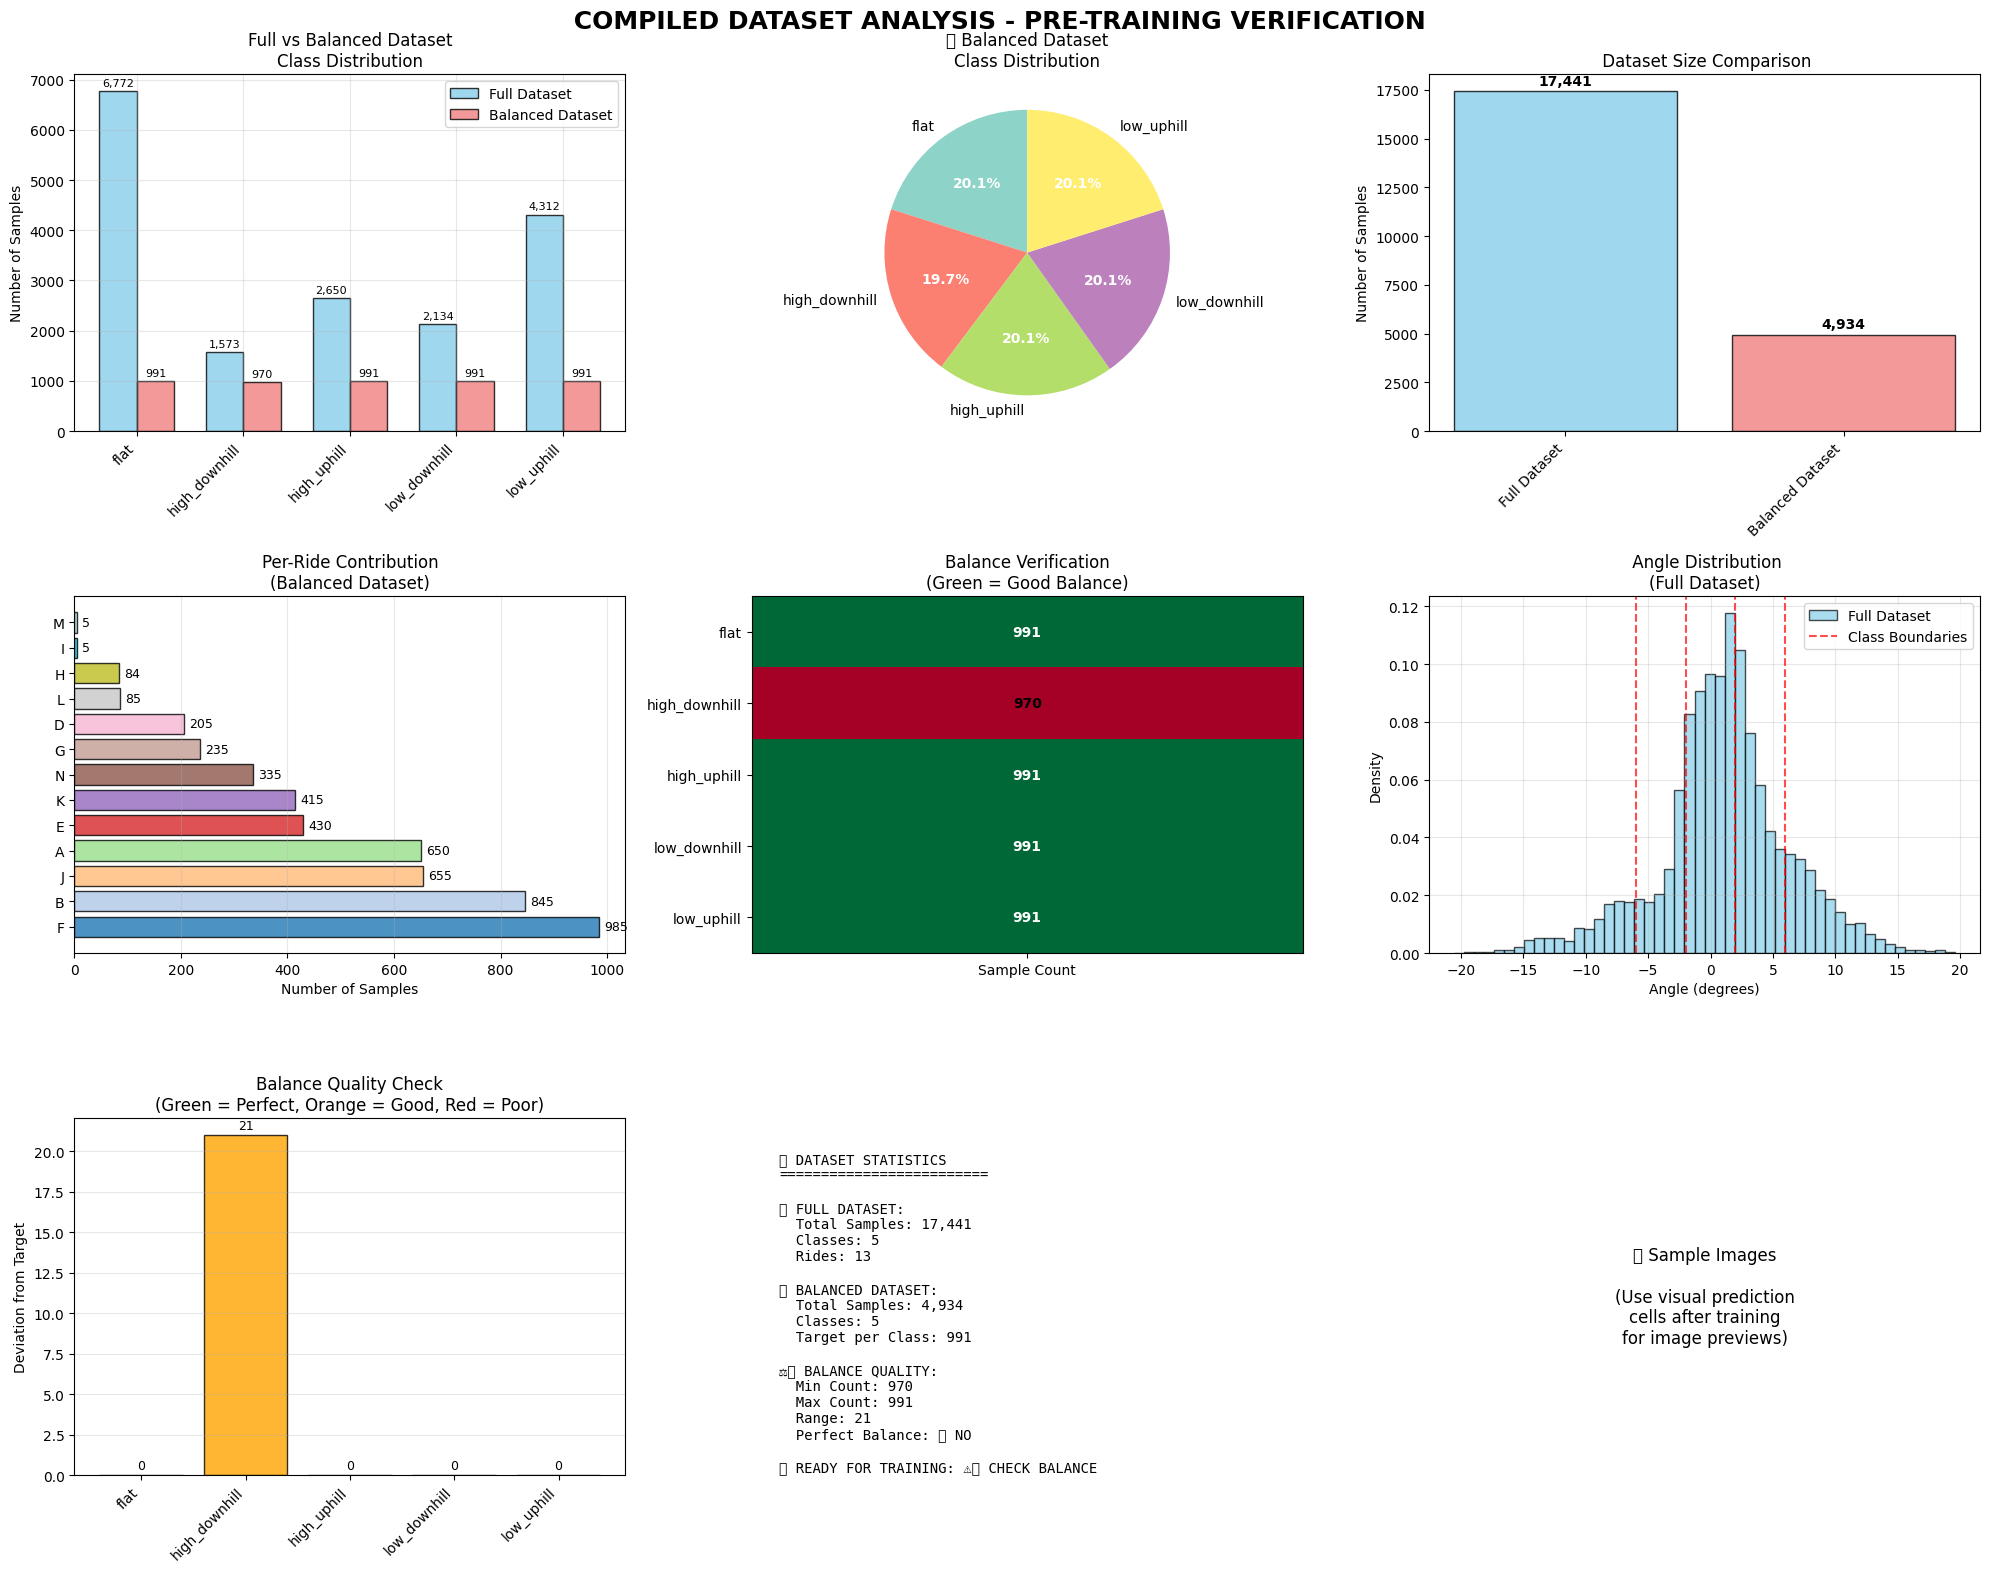


🎯 PRE-TRAINING VERIFICATION SUMMARY
✅ Total compiled samples: 4,934
✅ Number of classes: 5
✅ Number of rides: 13
⚠️  Balance check: Range 970-991 samples
✅ Ready for model training: CHECK BALANCE FIRST


In [ ]:
# COMPREHENSIVE DATASET VISUALIZATION - PRE-TRAINING ANALYSIS
print(" LOADING AND ANALYZING COMPILED DATASETS")
print("=" * 70)

try:
    # Load master datasets
    base_path = CONFIG['BASE_OUTPUT_DIR']
    balanced_path = os.path.join(base_path, 'ALL_RIDES_labels_balanced.csv')

    # Check if files exist
    if not os.path.exists(balanced_path):
        print(" Master balanced dataset not found!")
        print(f"   Expected at: {balanced_path}")
        print("   Please run the batch processing pipeline first (Cell 18)")
    else:
        # Load balanced dataset
        df_balanced = pd.read_csv(balanced_path)

        # Try to load full dataset (individual ride files)
        print(" Loading datasets...")
        print(f"Balanced dataset loaded: {len(df_balanced):,} samples")

        # Get all individual ride data for full dataset comparison
        ride_dirs = [d for d in os.listdir(base_path)
                    if os.path.isdir(os.path.join(base_path, d)) and d not in CONFIG['SKIP_FOLDERS']]

        full_data = []
        for ride in ride_dirs:
            ride_full_path = os.path.join(base_path, ride, 'labels.csv')
            if os.path.exists(ride_full_path):
                ride_df = pd.read_csv(ride_full_path)
                ride_df['ride_name'] = ride
                full_data.append(ride_df)

        if full_data:
            df_full = pd.concat(full_data, ignore_index=True)
            print(f" Full dataset compiled: {len(df_full):,} samples from {len(full_data)} rides")
        else:
            print("  Individual ride files not found, using balanced dataset for comparison")
            df_full = df_balanced.copy()

        # Create comprehensive visualization
        fig = plt.figure(figsize=(20, 16))
        fig.suptitle(' COMPILED DATASET ANALYSIS - PRE-TRAINING VERIFICATION',
                    fontsize=18, fontweight='bold', y=0.98)

        # Get data for plotting
        full_counts = df_full['label'].value_counts().sort_index()
        balanced_counts = df_balanced['label'].value_counts().sort_index()
        ride_counts = df_balanced['ride_name'].value_counts()

        # Color schemes
        class_colors = plt.cm.Set3(np.linspace(0, 1, len(balanced_counts)))
        ride_colors = plt.cm.tab20(np.linspace(0, 1, len(ride_counts)))

        # 1. Class Distribution Comparison (Bar Chart)
        plt.subplot(3, 3, 1)
        x = range(len(full_counts))
        width = 0.35
        plt.bar([i - width/2 for i in x], full_counts.values, width,
                label='Full Dataset', alpha=0.8, color='skyblue', edgecolor='black')
        plt.bar([i + width/2 for i in x], [balanced_counts.get(label, 0) for label in full_counts.index],
                width, label='Balanced Dataset', alpha=0.8, color='lightcoral', edgecolor='black')
        plt.xticks(x, full_counts.index, rotation=45, ha='right')
        plt.ylabel('Number of Samples')
        plt.title('Full vs Balanced Dataset\nClass Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Add count labels on bars
        for i, (full_val, bal_val) in enumerate(zip(full_counts.values,
                                                   [balanced_counts.get(label, 0) for label in full_counts.index])):
            plt.text(i - width/2, full_val + max(full_counts)*0.01, f'{full_val:,}',
                    ha='center', va='bottom', fontsize=8)
            plt.text(i + width/2, bal_val + max(full_counts)*0.01, f'{bal_val:,}',
                    ha='center', va='bottom', fontsize=8)

        # 2. Balanced Dataset Pie Chart
        plt.subplot(3, 3, 2)
        wedges, texts, autotexts = plt.pie(balanced_counts.values, labels=balanced_counts.index,
                                          autopct='%1.1f%%', colors=class_colors, startangle=90)
        plt.title('🎯 Balanced Dataset\nClass Distribution')
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')

        # 3. Sample Count Summary
        plt.subplot(3, 3, 3)
        datasets = ['Full Dataset', 'Balanced Dataset']
        counts = [len(df_full), len(df_balanced)]
        colors_summary = ['skyblue', 'lightcoral']
        bars = plt.bar(datasets, counts, color=colors_summary, alpha=0.8, edgecolor='black')
        plt.ylabel('Number of Samples')
        plt.title(' Dataset Size Comparison')
        plt.xticks(rotation=45, ha='right')

        # Add count labels
        for bar, count in zip(bars, counts):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01,
                    f'{count:,}', ha='center', va='bottom', fontweight='bold')

        # 4. Per-Ride Contribution (Horizontal Bar)
        plt.subplot(3, 3, 4)
        y_pos = range(len(ride_counts))
        plt.barh(y_pos, ride_counts.values, color=ride_colors, alpha=0.8, edgecolor='black')
        plt.yticks(y_pos, ride_counts.index)
        plt.xlabel('Number of Samples')
        plt.title('Per-Ride Contribution\n(Balanced Dataset)')
        plt.grid(True, alpha=0.3, axis='x')

        # Add count labels
        for i, count in enumerate(ride_counts.values):
            plt.text(count + max(ride_counts)*0.01, i, f'{count:,}',
                    va='center', ha='left', fontsize=9)

        # 5. Balance Verification Matrix
        plt.subplot(3, 3, 5)
        balance_data = []
        for label in balanced_counts.index:
            balance_data.append([balanced_counts[label]])

        im = plt.imshow(balance_data, cmap='RdYlGn', aspect='auto')
        plt.yticks(range(len(balanced_counts)), balanced_counts.index)
        plt.xticks([0], ['Sample Count'])
        plt.title('Balance Verification\n(Green = Good Balance)')

        # Add text annotations
        for i, count in enumerate(balanced_counts.values):
            plt.text(0, i, f'{count}', ha='center', va='center',
                    fontweight='bold', color='black' if count < np.mean(balanced_counts) else 'white')

        # 6. Angle Distribution (Full Dataset)
        plt.subplot(3, 3, 6)
        plt.hist(df_full['angle'], bins=50, alpha=0.7, color='skyblue',
                edgecolor='black', density=True, label='Full Dataset')
        plt.xlabel('Angle (degrees)')
        plt.ylabel('Density')
        plt.title(' Angle Distribution\n(Full Dataset)')
        plt.grid(True, alpha=0.3)
        plt.axvline(x=-6, color='red', linestyle='--', alpha=0.7, label='Class Boundaries')
        plt.axvline(x=-2, color='red', linestyle='--', alpha=0.7)
        plt.axvline(x=2, color='red', linestyle='--', alpha=0.7)
        plt.axvline(x=6, color='red', linestyle='--', alpha=0.7)
        plt.legend()

        # 7. Class Balance Verification (Detailed)
        plt.subplot(3, 3, 7)
        target_count = balanced_counts.iloc[0]  # Reference count
        deviations = [abs(count - target_count) for count in balanced_counts.values]
        colors_balance = ['green' if dev == 0 else 'orange' if dev < target_count*0.1 else 'red'
                         for dev in deviations]

        bars = plt.bar(range(len(balanced_counts)), deviations,
                      color=colors_balance, alpha=0.8, edgecolor='black')
        plt.xticks(range(len(balanced_counts)), balanced_counts.index, rotation=45, ha='right')
        plt.ylabel('Deviation from Target')
        plt.title('Balance Quality Check\n(Green = Perfect, Orange = Good, Red = Poor)')
        plt.grid(True, alpha=0.3, axis='y')

        # Add deviation labels
        for i, (bar, dev) in enumerate(zip(bars, deviations)):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(deviations)*0.01,
                    f'{dev}', ha='center', va='bottom', fontsize=9)

        # 8. Dataset Statistics Summary
        plt.subplot(3, 3, 8)
        plt.axis('off')
        stats_text = f"""
📊 DATASET STATISTICS
{'='*25}

📈 FULL DATASET:
  Total Samples: {len(df_full):,}
  Classes: {len(full_counts)}
  Rides: {len(df_full['ride_name'].unique())}

🎯 BALANCED DATASET:
  Total Samples: {len(df_balanced):,}
  Classes: {len(balanced_counts)}
  Target per Class: {balanced_counts.iloc[0]:,}

⚖️ BALANCE QUALITY:
  Min Count: {balanced_counts.min():,}
  Max Count: {balanced_counts.max():,}
  Range: {balanced_counts.max() - balanced_counts.min()}
  Perfect Balance: {'✅ YES' if balanced_counts.max() == balanced_counts.min() else '❌ NO'}

🎯 READY FOR TRAINING: {'✅ YES' if balanced_counts.max() - balanced_counts.min() <= 10 else '⚠️ CHECK BALANCE'}
        """
        plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes,
                verticalalignment='top', fontfamily='monospace', fontsize=10)

        # 9. Sample Images Preview (if available)
        plt.subplot(3, 3, 9)
        plt.axis('off')
        plt.text(0.5, 0.5, '🖼️ Sample Images\n\n(Use visual prediction\ncells after training\nfor image previews)',
                ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)

        plt.tight_layout()

        # Save the visualization
        viz_path = os.path.join(CONFIG['OUTPUT_DIR'], 'pre_training_dataset_analysis.png')
        os.makedirs(CONFIG['OUTPUT_DIR'], exist_ok=True)
        plt.savefig(viz_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"\n💾 Visualization saved to: {viz_path}")

        plt.show()

        # Print summary
        print("\n" + "🎯 PRE-TRAINING VERIFICATION SUMMARY")
        print("=" * 50)
        print(f"✅ Total compiled samples: {len(df_balanced):,}")
        print(f"✅ Number of classes: {len(balanced_counts)}")
        print(f"✅ Number of rides: {len(ride_counts)}")

        # Balance check
        if balanced_counts.max() == balanced_counts.min():
            print(f"✅ Perfect balance: All classes have {balanced_counts.iloc[0]:,} samples")
        else:
            print(f"⚠️  Balance check: Range {balanced_counts.min():,}-{balanced_counts.max():,} samples")

        print(f"✅ Ready for model training: {'YES' if balanced_counts.max() - balanced_counts.min() <= 10 else 'CHECK BALANCE FIRST'}")
        print("=" * 50)

except Exception as e:
    print(f" Error creating visualization: {e}")
    print("Please ensure the batch processing pipeline has been run successfully")

In [ ]:
# Prepare data for machine learning - UPDATED FOR MULTI-RIDE SUPPORT
print("="*80)
print("🧠 MACHINE LEARNING PIPELINE")
print("="*80)

# Check if master datasets are available from multi-ride processing
if 'master_balanced_df' in locals() and master_balanced_df is not None:
    print("🎯 Using MASTER BALANCED DATASET from multi-ride processing")
    df_ml = master_balanced_df.copy()
    print(f"📊 Master dataset includes {len(df_ml['ride_name'].unique())} rides")
    print(f"🔢 Total samples: {len(df_ml):,}")

    # Display per-ride contribution
    ride_distribution = df_ml['ride_name'].value_counts()
    print(f"📈 Samples per ride:")
    for ride, count in ride_distribution.items():
        percentage = (count / len(df_ml)) * 100
        print(f"    {ride}: {count:,} samples ({percentage:.1f}%)")

elif 'df_balanced' in locals() and df_balanced is not None:
    print("⚠️  Using SINGLE-RIDE DATASET (master datasets not available)")
    df_ml = df_balanced.copy()
    print(f"🔢 Total samples: {len(df_ml):,}")

else:
    # Fallback: try to load single ride data if it exists
    print("🔄 Attempting to load single-ride data...")
    try:
        # This will work if the single-ride pipeline was run
        df_ml = df_balanced.copy()
        print(f"✅ Loaded single-ride dataset: {len(df_ml):,} samples")
    except NameError:
        print("No dataset available! Please run either:")
        print("   1. Multi-ride processing pipeline (recommended), or")
        print("   2. Single-ride processing pipeline")
        raise ValueError("No dataset available for machine learning!")

print(f"\n📋 Dataset Summary:")
print(f"   • Total samples: {len(df_ml):,}")
print(f"   • Classes: {len(df_ml['label'].unique())}")

# Display label distribution
label_counts = df_ml['label'].value_counts()
print(f"\n📊 Label Distribution:")
for label, count in label_counts.items():
    percentage = (count / len(df_ml)) * 100
    print(f"   {label:15}: {count:6d} samples ({percentage:5.1f}%)")

# Create stratified train-validation split
print(f"\n🔄 Creating train-validation split...")
train_df, val_df = train_test_split(
    df_ml,
    test_size=CONFIG['VALIDATION_SPLIT'],
    stratify=df_ml['label'],
    random_state=CONFIG['RANDOM_STATE']
)

print(f"✅ Data split completed:")
print(f"   • Training samples: {len(train_df):,}")
print(f"   • Validation samples: {len(val_df):,}")

# Setup label encoding
print(f"\n🏷️  Setting up label encoding...")
label_encoder = LabelEncoder()
label_encoder.fit(df_ml['label'])

# Apply encoding to train/validation sets
train_df = train_df.copy()
val_df = val_df.copy()
train_df['label_enc'] = label_encoder.transform(train_df['label'])
val_df['label_enc'] = label_encoder.transform(val_df['label'])

print(f"📝 Label encoding completed:")
print(f"   • Number of classes: {len(label_encoder.classes_)}")
print(f"   • Classes: {list(label_encoder.classes_)}")

print(f"\n🚀 Ready for model training!")
print("="*80)

🧠 MACHINE LEARNING PIPELINE
🎯 Using MASTER BALANCED DATASET from multi-ride processing
📊 Master dataset includes 13 rides
🔢 Total samples: 4,934
📈 Samples per ride:
    F: 985 samples (20.0%)
    B: 845 samples (17.1%)
    J: 655 samples (13.3%)
    A: 650 samples (13.2%)
    E: 430 samples (8.7%)
    K: 415 samples (8.4%)
    N: 335 samples (6.8%)
    G: 235 samples (4.8%)
    D: 205 samples (4.2%)
    L: 85 samples (1.7%)
    H: 84 samples (1.7%)
    I: 5 samples (0.1%)
    M: 5 samples (0.1%)

📋 Dataset Summary:
   • Total samples: 4,934
   • Classes: 5

📊 Label Distribution:
   low_uphill     :    991 samples ( 20.1%)
   low_downhill   :    991 samples ( 20.1%)
   high_uphill    :    991 samples ( 20.1%)
   flat           :    991 samples ( 20.1%)
   high_downhill  :    970 samples ( 19.7%)

🔄 Creating train-validation split...
✅ Data split completed:
   • Training samples: 3,947
   • Validation samples: 987

🏷️  Setting up label encoding...
📝 Label encoding completed:
   • Number 

In [ ]:
def create_data_pipeline(train_df, val_df, img_size=(224, 224), batch_size=32):
    """
    Create optimized TensorFlow data pipelines for training and validation with optional augmentation
    """
    print("Creating TensorFlow data pipelines...")
    if CONFIG['USE_AUGMENTATION']:
        print("🔄 Data augmentation ENABLED - using research-backed parameters")
    else:
        print("📊 Data augmentation DISABLED - using original images only")

    def load_and_preprocess_image(path):
        """Load and preprocess image for training"""
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, img_size)
        img = tf.cast(img, tf.float32) / 255.0
        return img

    def augment_image(img):
        """Apply data augmentation - FIXED VERSION"""
        if not CONFIG['USE_AUGMENTATION']:
            return img

        # Random horizontal flip
        if CONFIG['AUG_HORIZONTAL_FLIP']:
            img = tf.image.random_flip_left_right(img)

        # Random brightness adjustment
        if CONFIG['AUG_BRIGHTNESS_RANGE'] > 0:
            img = tf.image.random_brightness(img, CONFIG['AUG_BRIGHTNESS_RANGE'])

        # Random contrast - FIXED
        if len(CONFIG['AUG_CONTRAST_RANGE']) == 2:
            lower, upper = CONFIG['AUG_CONTRAST_RANGE']
            img = tf.image.random_contrast(img, lower, upper)

        # Random saturation - FIXED
        if len(CONFIG['AUG_SATURATION_RANGE']) == 2:
            lower, upper = CONFIG['AUG_SATURATION_RANGE']
            img = tf.image.random_saturation(img, lower, upper)

        # REMOVED PROBLEMATIC ZOOM AUGMENTATION

        # Add slight Gaussian noise
        if CONFIG['AUG_NOISE_FACTOR'] > 0:
            noise = tf.random.normal(tf.shape(img), mean=0.0, stddev=CONFIG['AUG_NOISE_FACTOR'])
            img = tf.add(img, noise)

        # Ensure values stay in valid range [0, 1]
        img = tf.clip_by_value(img, 0.0, 1.0)
        return img

    def load_example(image_path, label, is_training=True):
        """Load a single training example with optional augmentation"""
        image = load_and_preprocess_image(image_path)

        if is_training and CONFIG['USE_AUGMENTATION']:
            image = augment_image(image)

        label = tf.cast(label, tf.int32)
        return image, label

    # Prepare file paths and labels
    train_paths = train_df['frame_path'].values
    train_labels = train_df['label_enc'].values
    val_paths = val_df['frame_path'].values
    val_labels = val_df['label_enc'].values

    print(f"Training samples: {len(train_paths):,}")
    print(f"Validation samples: {len(val_paths):,}")

    # Create training dataset
    train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    train_ds = train_ds.map(
        lambda x, y: load_example(x, y, is_training=True),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    train_ds = train_ds.shuffle(buffer_size=len(train_paths))
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

    # Create validation dataset
    val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
    val_ds = val_ds.map(
        lambda x, y: load_example(x, y, is_training=False),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    val_ds = val_ds.batch(batch_size)
    val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

    print("Data pipelines created successfully!")
    print("✅ Fixed zoom augmentation issue")
    return train_ds, val_ds

# Recreate data pipelines with fix
train_ds, val_ds = create_data_pipeline(
    train_df, val_df,
    img_size=CONFIG['IMG_SIZE'],
    batch_size=CONFIG['BATCH_SIZE']
)

Creating TensorFlow data pipelines...
🔄 Data augmentation ENABLED - using research-backed parameters
Training samples: 3,947
Validation samples: 987
Data pipelines created successfully!
✅ Fixed zoom augmentation issue


In [ ]:
def create_simplified_model(n_classes, img_shape=(224, 224, 3), dropout_rate=0.3):
    """
    Create a simplified CNN model using MobileNetV2 - OPTIMIZED VERSION
    """
    print("Building simplified CNN model architecture...")

    # Load pre-trained MobileNetV2 base
    base_model = MobileNetV2(
        input_shape=img_shape,
        include_top=False,
        weights='imagenet'
    )

    # Freeze base model
    base_model.trainable = False

    # Build simple sequential model (like your working one)
    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(dropout_rate),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(n_classes, activation='softmax')
    ], name='slope_classifier')

    print(f"Model architecture created!")
    print(f"Base Model: MobileNetV2")
    print(f"Output classes: {n_classes}")
    print(f"Architecture: Sequential (Simple & Effective)")

    return model

# Create the simplified model - NO MORE COMPLEX ARCHITECTURE
n_classes = len(label_encoder.classes_)
model = create_simplified_model(
    n_classes=n_classes,
    img_shape=(*CONFIG['IMG_SIZE'], 3),
    dropout_rate=0.3  # Same as your working model
)

# BUILD the model
print("Building model with sample input...")
sample_input = tf.random.normal([1, *CONFIG['IMG_SIZE'], 3])
_ = model(sample_input)

# Display model summary
print("\nModel Summary:")
model.summary()

Building simplified CNN model architecture...
Model architecture created!
Base Model: MobileNetV2
Output classes: 5
Architecture: Sequential (Simple & Effective)
Building model with sample input...

Model Summary:


Model: "slope_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,109 (9.24 MB)

 Trainable params: 164,869 (644.02 KB)

 Non-trainable params: 2,258,240 (8.61 MB)

In [ ]:
# Compile model and setup callbacks
model.compile(
    optimizer=optimizers.Adam(learning_rate=CONFIG['LEARNING_RATE']),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled!")
print(f"Optimizer: Adam (lr={CONFIG['LEARNING_RATE']})")
print(f"Loss: Sparse Categorical Crossentropy")

# Test the model with a sample batch to ensure it's working
print("Testing model with sample batch...")
try:
    for sample_images, sample_labels in train_ds.take(1):
        print(f"Sample batch shape: {sample_images.shape}")
        print(f"Sample labels shape: {sample_labels.shape}")

        # Test forward pass
        predictions = model(sample_images, training=False)
        print(f"Predictions shape: {predictions.shape}")
        print("✅ Model forward pass successful!")
        break
except Exception as e:
    print(f"❌ Model test failed: {e}")
    raise

# Setup callbacks
checkpoint_path = os.path.join(CONFIG['OUTPUT_DIR'], 'best_slope_model.keras')  # Keep .keras extension
log_path = os.path.join(CONFIG['OUTPUT_DIR'], 'training_log.csv')

callbacks = [
    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_loss',
        patience=CONFIG['PATIENCE'],
        restore_best_weights=True,
        verbose=1,
        mode='min'
    ),

    # Save best model
    ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1,
        mode='max'

    ),

    # Reduce learning rate on plateau
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1,
        mode='min'
    ),

    # Log training metrics
    tf.keras.callbacks.CSVLogger(
        log_path,
        separator=',',
        append=False
    )
]

print("Callbacks configured:")
print(f"  • Early Stopping (patience={CONFIG['PATIENCE']})")
print(f"  • Model Checkpoint → {checkpoint_path}")
print(f"  • Learning Rate Reduction")
print(f"  • CSV Logger → {log_path}")

print("🚀 Model is ready for training!")

Model compiled!
Optimizer: Adam (lr=0.001)
Loss: Sparse Categorical Crossentropy
Testing model with sample batch...
Sample batch shape: (32, 224, 224, 3)
Sample labels shape: (32,)
Predictions shape: (32, 5)
✅ Model forward pass successful!
Callbacks configured:
  • Early Stopping (patience=5)
  • Model Checkpoint → /content/drive/MyDrive/msc proj- data/June_3_25/Model_Output/best_slope_model.keras
  • Learning Rate Reduction
  • CSV Logger → /content/drive/MyDrive/msc proj- data/June_3_25/Model_Output/training_log.csv
🚀 Model is ready for training!


In [ ]:
# Train the model
print("Starting model training...")
print("="*60)

print(f"Training Configuration:")
print(f"  • Max epochs: {CONFIG['EPOCHS']}")
print(f"  • Batch size: {CONFIG['BATCH_SIZE']}")
print(f"  • Learning rate: {CONFIG['LEARNING_RATE']}")
print(f"  • Early stopping patience: {CONFIG['PATIENCE']}")

print("="*60)
print("Training started!")

start_time = datetime.now()

history = model.fit(
    train_ds,
    epochs=CONFIG['EPOCHS'],
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1
)

end_time = datetime.now()
training_duration = end_time - start_time

print("Training completed successfully!")
print(f"Training duration: {training_duration}")
print(f"Epochs completed: {len(history.history['loss'])}")

# Display final metrics
final_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"\nFinal Training Metrics:")
print(f"  • Training Loss: {final_loss:.4f}")
print(f"  • Validation Loss: {final_val_loss:.4f}")
print(f"  • Training Accuracy: {final_acc:.4f}")
print(f"  • Validation Accuracy: {final_val_acc:.4f}")

print("\nTraining phase completed!")

Starting model training...
Training Configuration:
  • Max epochs: 30
  • Batch size: 32
  • Learning rate: 0.001
  • Early stopping patience: 5
Training started!
Epoch 1/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.3316 - loss: 1.7000
Epoch 1: val_accuracy improved from -inf to 0.44478, saving model to /content/drive/MyDrive/msc proj- data/June_3_25/Model_Output/best_slope_model.keras
124/124 ━━━━━━━━━━━━━━━━━━━━ 106s 490ms/step - accuracy: 0.3321 - loss: 1.6987 - val_accuracy: 0.4448 - val_loss: 1.3271 - learning_rate: 0.0010
Epoch 2/30
123/124 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4878 - loss: 1.2612
Epoch 2: val_accuracy improved from 0.44478 to 0.54407, saving model to /content/drive/MyDrive/msc proj- data/June_3_25/Model_Output/best_slope_model.keras
124/124 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - accuracy: 0.4878 - loss: 1.2611 - val_accuracy: 0.5441 - val_loss: 1.1507 - learning_rate: 0.0010
Epoch 3/30
122/124 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 

## Model  Evaluation


Creating training history visualizations...
Training history plot saved to: /content/drive/MyDrive/msc proj- data/June_3_25/Model_Output/training_history.png


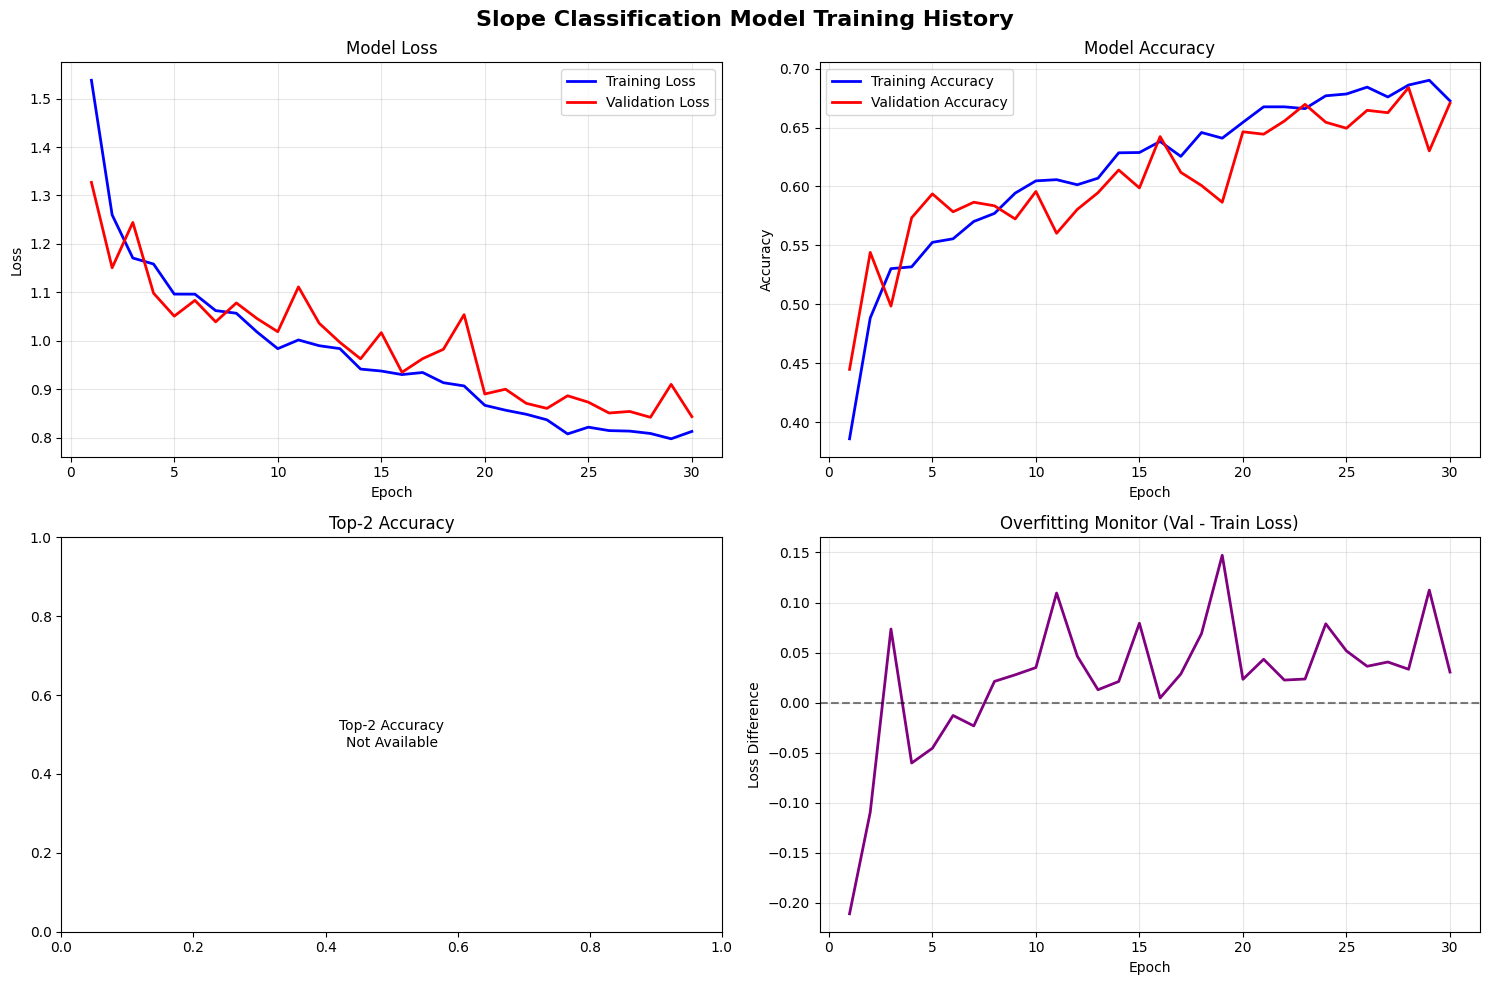


Training Summary:
  • Total epochs: 30
  • Final training loss: 0.8127
  • Final validation loss: 0.8433
  • Final training accuracy: 0.6727
  • Final validation accuracy: 0.6707


In [ ]:
def plot_training_history(history, save_path=None):
    """
    Create comprehensive training history plots
    """
    print("Creating training history visualizations...")

    # Extract history data
    if hasattr(history, 'history'):
        hist_dict = history.history
    else:
        hist_dict = history

    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Slope Classification Model Training History', fontsize=16, fontweight='bold')

    epochs = range(1, len(hist_dict['loss']) + 1)

    # Plot 1: Loss
    axes[0, 0].plot(epochs, hist_dict['loss'], 'b-', label='Training Loss', linewidth=2)
    axes[0, 0].plot(epochs, hist_dict['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    axes[0, 0].set_title('Model Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Accuracy
    axes[0, 1].plot(epochs, hist_dict['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    axes[0, 1].plot(epochs, hist_dict['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    axes[0, 1].set_title('Model Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Top-2 Accuracy (if available)
    if 'top_2_accuracy' in hist_dict:
        axes[1, 0].plot(epochs, hist_dict['top_2_accuracy'], 'g-', label='Training Top-2', linewidth=2)
        axes[1, 0].plot(epochs, hist_dict['val_top_2_accuracy'], 'orange', label='Validation Top-2', linewidth=2)
        axes[1, 0].set_title('Top-2 Accuracy')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Top-2 Accuracy')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    else:
        # Plot learning rate if available
        if 'lr' in hist_dict:
            axes[1, 0].plot(epochs, hist_dict['lr'], 'purple', linewidth=2)
            axes[1, 0].set_title('Learning Rate')
            axes[1, 0].set_xlabel('Epoch')
            axes[1, 0].set_ylabel('Learning Rate')
            axes[1, 0].set_yscale('log')
            axes[1, 0].grid(True, alpha=0.3)
        else:
            axes[1, 0].text(0.5, 0.5, 'Top-2 Accuracy\nNot Available',
                           ha='center', va='center', transform=axes[1, 0].transAxes)
            axes[1, 0].set_title('Top-2 Accuracy')

    # Plot 4: Loss difference (overfitting monitor)
    loss_diff = [val - train for train, val in zip(hist_dict['loss'], hist_dict['val_loss'])]
    axes[1, 1].plot(epochs, loss_diff, 'purple', linewidth=2)
    axes[1, 1].set_title('Overfitting Monitor (Val - Train Loss)')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss Difference')
    axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Training history plot saved to: {save_path}")

    plt.show()

    # Print summary statistics
    print(f"\nTraining Summary:")
    print(f"  • Total epochs: {len(epochs)}")
    print(f"  • Final training loss: {hist_dict['loss'][-1]:.4f}")
    print(f"  • Final validation loss: {hist_dict['val_loss'][-1]:.4f}")
    print(f"  • Final training accuracy: {hist_dict['accuracy'][-1]:.4f}")
    print(f"  • Final validation accuracy: {hist_dict['val_accuracy'][-1]:.4f}")

# Plot training history - FIXED variable reference
history_plot_path = os.path.join(CONFIG['OUTPUT_DIR'], 'training_history.png')
plot_training_history(history, history_plot_path)

In [ ]:
def comprehensive_model_evaluation(model, val_ds, label_encoder, output_dir):
    """
    Perform comprehensive model evaluation
    """
    print("Performing comprehensive model evaluation...")

    # Get predictions
    print("Generating predictions on validation set...")
    y_true = np.concatenate([y for x, y in val_ds], axis=0)
    y_pred_probs = model.predict(val_ds, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    # Top-2 accuracy
    top2_acc = np.mean([
        true_label in np.argsort(pred_probs)[-2:]
        for true_label, pred_probs in zip(y_true, y_pred_probs)
    ])

    print(f"Evaluation Metrics:")
    print(f"  • Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  • F1-Score (Macro): {f1_macro:.4f}")
    print(f"  • F1-Score (Weighted): {f1_weighted:.4f}")
    print(f"  • Top-2 Accuracy: {top2_acc:.4f} ({top2_acc*100:.2f}%)")

    # Detailed classification report
    print(f"\nDetailed Classification Report:")
    class_report = classification_report(
        y_true, y_pred,
        target_names=label_encoder.classes_,
        output_dict=True
    )

    print(classification_report(
        y_true, y_pred,
        target_names=label_encoder.classes_
    ))

    evaluation_results = {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'top2_accuracy': top2_acc,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_probs': y_pred_probs,
        'classification_report': class_report
    }

    return evaluation_results

# Perform comprehensive evaluation - FIXED variable reference
evaluation_results = comprehensive_model_evaluation(
    model, val_ds, label_encoder, CONFIG['OUTPUT_DIR']
)

Performing comprehensive model evaluation...
Generating predictions on validation set...
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 302ms/step
Evaluation Metrics:
  • Accuracy: 0.6839 (68.39%)
  • F1-Score (Macro): 0.6798
  • F1-Score (Weighted): 0.6793
  • Top-2 Accuracy: 0.8744 (87.44%)

Detailed Classification Report:
               precision    recall  f1-score   support

         flat       0.61      0.65      0.63       198
high_downhill       0.73      0.84      0.78       194
  high_uphill       0.76      0.83      0.79       198
 low_downhill       0.64      0.58      0.61       199
   low_uphill       0.66      0.53      0.59       198

     accuracy                           0.68       987
    macro avg       0.68      0.68      0.68       987
 weighted avg       0.68      0.68      0.68       987



Creating evaluation visualizations...
Evaluation plots saved to: /content/drive/MyDrive/msc proj- data/June_3_25/Model_Output/comprehensive_evaluation.png


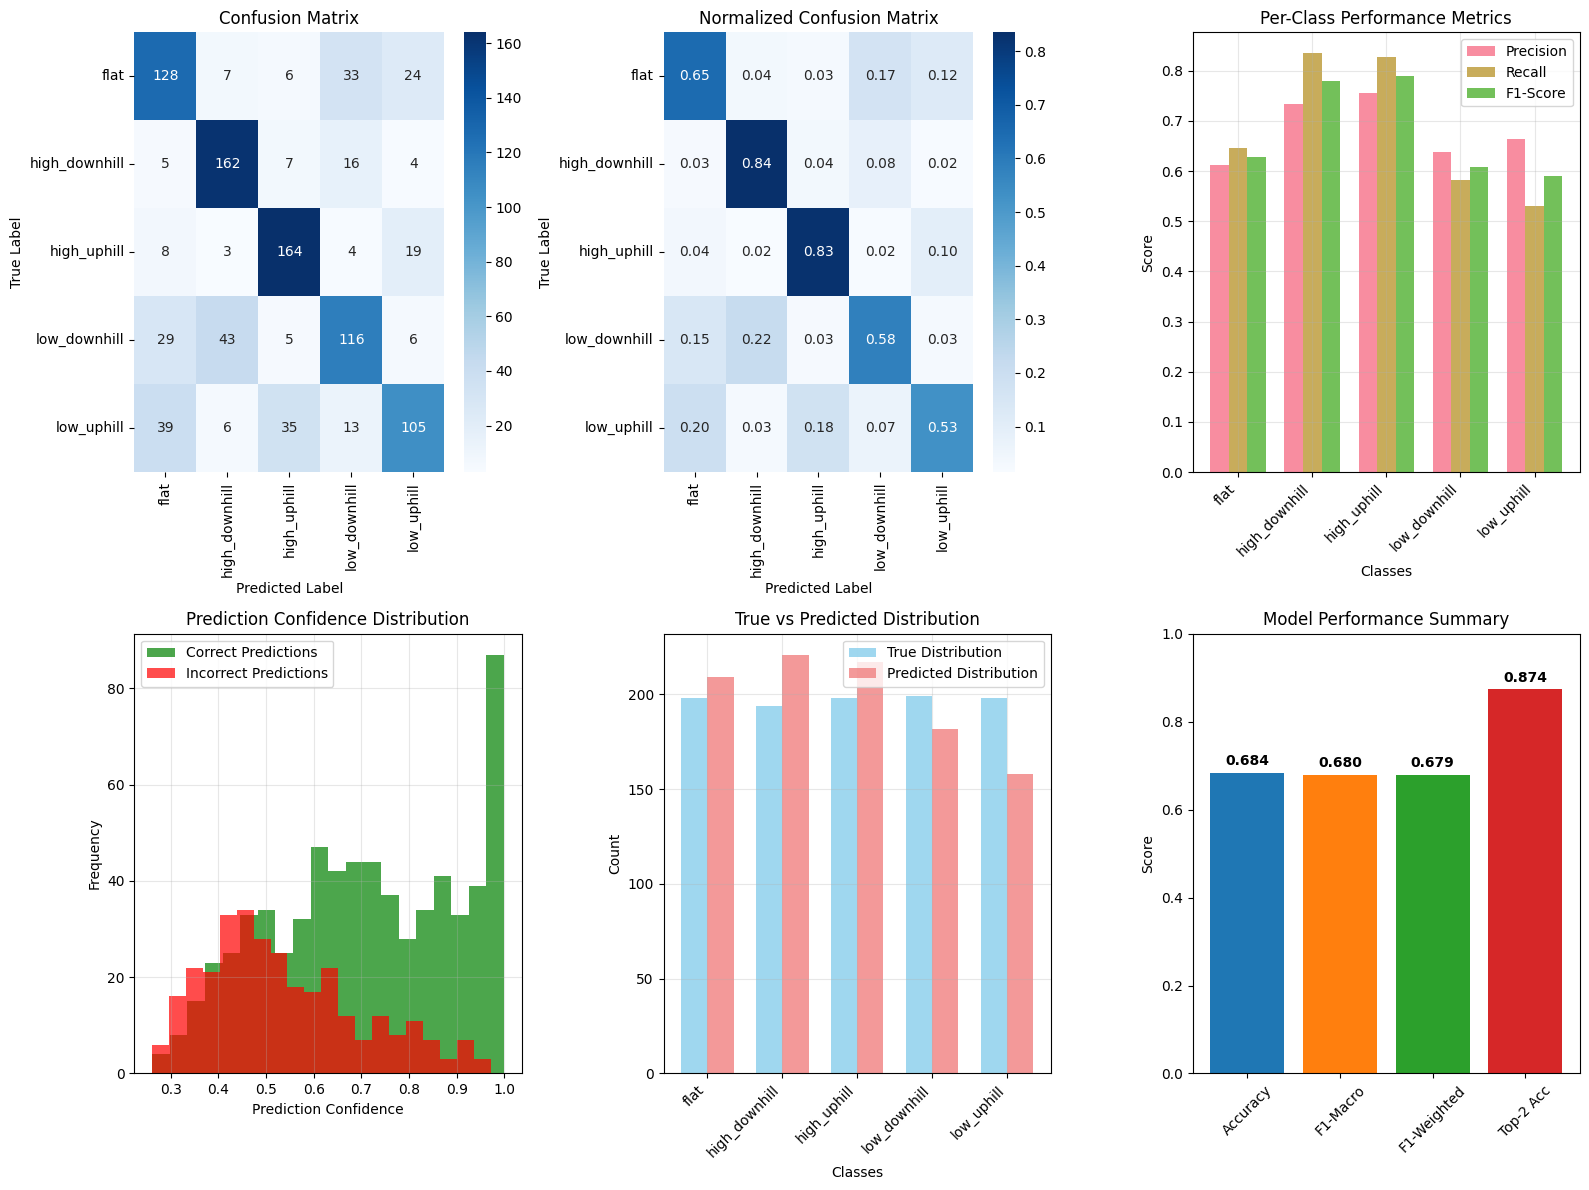

In [ ]:
def create_evaluation_plots(evaluation_results, label_encoder, output_dir):
    """
    Create advanced evaluation visualizations
    """
    print("Creating evaluation visualizations...")

    y_true = evaluation_results['y_true']
    y_pred = evaluation_results['y_pred']
    y_pred_probs = evaluation_results['y_pred_probs']

    # Create figure with multiple subplots
    fig = plt.figure(figsize=(16, 12))

    # 1. Confusion Matrix
    plt.subplot(2, 3, 1)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # 2. Normalized Confusion Matrix
    plt.subplot(2, 3, 2)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # 3. Per-class Performance Metrics - FIXED
    plt.subplot(2, 3, 3)
    class_report = evaluation_results['classification_report']
    classes = label_encoder.classes_

    # Fix: Use class names as keys, not numeric indices
    precision_scores = [class_report[class_name]['precision'] for class_name in classes]
    recall_scores = [class_report[class_name]['recall'] for class_name in classes]
    f1_scores = [class_report[class_name]['f1-score'] for class_name in classes]

    x = np.arange(len(classes))
    width = 0.25

    plt.bar(x - width, precision_scores, width, label='Precision', alpha=0.8)
    plt.bar(x, recall_scores, width, label='Recall', alpha=0.8)
    plt.bar(x + width, f1_scores, width, label='F1-Score', alpha=0.8)

    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Per-Class Performance Metrics')
    plt.xticks(x, classes, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 4. Prediction Confidence Distribution
    plt.subplot(2, 3, 4)
    max_probs = np.max(y_pred_probs, axis=1)
    correct_predictions = (y_true == y_pred)

    plt.hist(max_probs[correct_predictions], bins=20, alpha=0.7,
             label='Correct Predictions', color='green')
    plt.hist(max_probs[~correct_predictions], bins=20, alpha=0.7,
             label='Incorrect Predictions', color='red')
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Frequency')
    plt.title('Prediction Confidence Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 5. Class Distribution Comparison
    plt.subplot(2, 3, 5)
    true_dist = np.bincount(y_true)
    pred_dist = np.bincount(y_pred)

    x = range(len(label_encoder.classes_))
    width = 0.35

    plt.bar([i - width/2 for i in x], true_dist, width,
            label='True Distribution', alpha=0.8, color='skyblue')
    plt.bar([i + width/2 for i in x], pred_dist, width,
            label='Predicted Distribution', alpha=0.8, color='lightcoral')

    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.title('True vs Predicted Distribution')
    plt.xticks(x, label_encoder.classes_, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 6. Model Performance Summary
    plt.subplot(2, 3, 6)
    metrics = ['Accuracy', 'F1-Macro', 'F1-Weighted', 'Top-2 Acc']
    values = [
        evaluation_results['accuracy'],
        evaluation_results['f1_macro'],
        evaluation_results['f1_weighted'],
        evaluation_results['top2_accuracy']
    ]

    bars = plt.bar(metrics, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    plt.ylim(0, 1)
    plt.ylabel('Score')
    plt.title('Model Performance Summary')
    plt.xticks(rotation=45)

    # Add value labels on bars
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()

    # Save the evaluation plot
    eval_plot_path = os.path.join(output_dir, 'comprehensive_evaluation.png')
    plt.savefig(eval_plot_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"Evaluation plots saved to: {eval_plot_path}")

    plt.show()

# Create evaluation plots
create_evaluation_plots(evaluation_results, label_encoder, CONFIG['OUTPUT_DIR'])

In [ ]:
def generate_final_report(evaluation_results, history, model, output_dir):
    """
    Generate a comprehensive final report with all model details and performance metrics

    Args:
        evaluation_results (dict): Dictionary containing evaluation metrics
        history: Training history object
        model: Trained model
        output_dir (str): Directory to save the report

    Returns:
        str: Path to the generated report file
    """
    print("Generating comprehensive final report...")

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Create report file path
    report_path = os.path.join(output_dir, 'FINAL_MODEL_REPORT.txt')

    # Generate report content
    with open(report_path, 'w') as f:
        f.write("SLOPE CLASSIFICATION MODEL - FINAL COMPREHENSIVE REPORT\n")
        f.write("=" * 70 + "\n\n")

        # Report metadata
        f.write(f"Report Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Project: Multi-Batch Slope Classification Pipeline\n")
        f.write(f"Model Architecture: MobileNetV2 Transfer Learning\n\n")

        # Model Configuration
        f.write("MODEL CONFIGURATION\n")
        f.write("-" * 30 + "\n")
        f.write(f"Image Size: {CONFIG['IMG_SIZE']}\n")
        f.write(f"Batch Size: {CONFIG['BATCH_SIZE']}\n")
        f.write(f"Learning Rate: {CONFIG['LEARNING_RATE']}\n")
        f.write(f"Dropout Rate: {CONFIG['DROPOUT_RATE']}\n")
        f.write(f"Max Epochs: {CONFIG['EPOCHS']}\n")
        f.write(f"Early Stopping Patience: {CONFIG['PATIENCE']}\n\n")

        # Training Results
        f.write("TRAINING RESULTS\n")
        f.write("-" * 30 + "\n")
        f.write(f"Epochs Completed: {len(history.history['loss'])}\n")
        f.write(f"Final Training Loss: {history.history['loss'][-1]:.4f}\n")
        f.write(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}\n")
        f.write(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}\n")
        f.write(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}\n\n")

        # Best Performance
        best_val_acc = max(history.history['val_accuracy'])
        best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
        f.write(f"Best Validation Accuracy: {best_val_acc:.4f} (Epoch {best_epoch})\n")
        f.write(f"Best Training Loss: {min(history.history['loss']):.4f}\n")
        f.write(f"Best Validation Loss: {min(history.history['val_loss']):.4f}\n\n")

        # Evaluation Metrics
        f.write("FINAL EVALUATION METRICS\n")
        f.write("-" * 30 + "\n")
        f.write(f"Test Accuracy: {evaluation_results['accuracy']:.4f} ({evaluation_results['accuracy']*100:.2f}%)\n")
        f.write(f"F1-Score (Macro): {evaluation_results['f1_macro']:.4f}\n")
        f.write(f"F1-Score (Weighted): {evaluation_results['f1_weighted']:.4f}\n")
        f.write(f"Top-2 Accuracy: {evaluation_results['top2_accuracy']:.4f} ({evaluation_results['top2_accuracy']*100:.2f}%)\n\n")

        # Class-wise Performance
        f.write("CLASS-WISE PERFORMANCE\n")
        f.write("-" * 30 + "\n")
        class_report = evaluation_results['classification_report']
        for class_name in ['flat', 'low_uphill', 'low_downhill', 'high_uphill', 'high_downhill']:
            if class_name in class_report:
                metrics = class_report[class_name]
                f.write(f"{class_name:15}: Precision={metrics['precision']:.3f}, "
                       f"Recall={metrics['recall']:.3f}, F1={metrics['f1-score']:.3f}, "
                       f"Support={metrics['support']}\n")
        f.write(f"\nMacro Average:    Precision={class_report['macro avg']['precision']:.3f}, "
               f"Recall={class_report['macro avg']['recall']:.3f}, "
               f"F1={class_report['macro avg']['f1-score']:.3f}\n")
        f.write(f"Weighted Average: Precision={class_report['weighted avg']['precision']:.3f}, "
               f"Recall={class_report['weighted avg']['recall']:.3f}, "
               f"F1={class_report['weighted avg']['f1-score']:.3f}\n\n")

        # Dataset Information
        f.write("DATASET INFORMATION\n")
        f.write("-" * 30 + "\n")
        if 'master_balanced_df' in globals():
            f.write("Dataset Type: Multi-Ride Master Dataset\n")
            f.write(f"Total Samples: {len(master_balanced_df):,}\n")
            ride_counts = master_balanced_df['ride_name'].value_counts()
            f.write(f"Number of Rides: {len(ride_counts)}\n")
            f.write("Samples per Ride:\n")
            for ride, count in ride_counts.items():
                f.write(f"  {ride}: {count:,} samples\n")
        else:
            f.write("Dataset Type: Single-Ride Dataset\n")

        f.write(f"\nClass Distribution:\n")
        if 'df_ml' in globals():
            label_counts = df_ml['label'].value_counts()
            for label, count in label_counts.items():
                percentage = (count / len(df_ml)) * 100
                f.write(f"  {label:15}: {count:6d} samples ({percentage:5.1f}%)\n")

        # Output Files
        f.write("\nOUTPUT FILES\n")
        f.write("-" * 30 + "\n")
        f.write(f"Model File: {os.path.join(output_dir, 'best_slope_model.keras')}\n")
        f.write(f"Training History Plot: {os.path.join(output_dir, 'training_history.png')}\n")
        f.write(f"Evaluation Plots: {os.path.join(output_dir, 'comprehensive_evaluation.png')}\n")
        f.write(f"Visual Predictions: {os.path.join(output_dir, 'visual_predictions.png')}\n")
        f.write(f"Training Log: {os.path.join(output_dir, 'training_log.csv')}\n")

        # Recommendations
        f.write("\nRECOMMENDations FOR FUTURE WORK\n")
        f.write("-" * 30 + "\n")
        if evaluation_results['accuracy'] > 0.8:
            f.write("✅ Model performance is good (>80% accuracy)\n")
        elif evaluation_results['accuracy'] > 0.7:
            f.write("⚠️  Model performance is acceptable (70-80% accuracy)\n")
            f.write("   Consider: More training data, data augmentation, hyperparameter tuning\n")
        else:
            f.write("❌ Model performance needs improvement (<70% accuracy)\n")
            f.write("   Consider: More diverse training data, different architecture, feature engineering\n")

        f.write("\n" + "=" * 70 + "\n")
        f.write("END OF REPORT\n")

    print(f"Final report saved to: {report_path}")
    return report_path

In [ ]:
# Generate final comprehensive report
final_report_path = generate_final_report(
    evaluation_results, history, model, CONFIG['OUTPUT_DIR']
)

# Determine dataset type used for training
dataset_info = ""
if 'master_balanced_df' in locals() and master_balanced_df is not None:
    dataset_info = f"🎯 MULTI-RIDE DATASET ({len(master_balanced_df['ride_name'].unique())} rides combined)"
    total_samples = len(master_balanced_df)
else:
    dataset_info = "⚠️  SINGLE-RIDE DATASET"
    total_samples = len(df_ml) if 'df_ml' in locals() else 0

print("\n" + "="*80)
print("🎊 CONGRATULATIONS! SLOPE CLASSIFICATION PROJECT COMPLETED! 🎊")
print("="*80)
print(f"\n🏆 Project Summary:")
print(f"• Dataset Type: {dataset_info}")
print(f"• Total Training Samples: {total_samples:,}")
print(f"• Model Accuracy: {evaluation_results['accuracy']:.3f} ({evaluation_results['accuracy']*100:.1f}%)")
print(f"• F1-Score (Weighted): {evaluation_results['f1_weighted']:.3f}")
print(f"• Classes: {len(label_encoder.classes_)}")
print(f"• Training Epochs: {len(history.history['loss'])}")

# Show output directories based on processing type - FIXED variable references
if 'master_balanced_df' in locals() and master_balanced_df is not None:
    print(f"• Multi-ride Output: {CONFIG['BASE_OUTPUT_DIR']}")
    print(f"• Model Output: {CONFIG['OUTPUT_DIR']}")
    print(f"\n📁 Available Outputs:")
    print(f"   • Per-ride datasets: {CONFIG['BASE_OUTPUT_DIR']}/<RideName>/")
    print(f"   • Master datasets: {CONFIG['BASE_OUTPUT_DIR']}/ALL_RIDES_labels_*.csv")
    print(f"   • Trained model: {CONFIG['OUTPUT_DIR']}/best_slope_model.keras")
    print(f"   • Multi-ride report: {CONFIG['BASE_OUTPUT_DIR']}/MULTI_RIDE_PROCESSING_REPORT.txt")
else:
    print(f"• Output Directory: {CONFIG['OUTPUT_DIR']}")
    print(f"\n📁 Available Outputs:")
    print(f"   • Single-ride dataset: {CONFIG['OUTPUT_DIR']}/labels*.csv")
    print(f"   • Trained model: {CONFIG['OUTPUT_DIR']}/best_slope_model.keras")

print(f"   • Final model report: {final_report_path}")

print(f"\n🚀 Next Steps:")
print(f"   ✅ Model ready for deployment and inference")
if 'master_balanced_df' in locals() and master_balanced_df is not None:
    print(f"   ✅ Multi-ride pipeline provides robust training data")
    print(f"   ✅ Master datasets can be used for future experiments")
else:
    print(f"   💡 Consider running multi-ride processing for better performance")
    print(f"   💡 Multi-ride data can improve model generalization")

print("="*80)

Generating comprehensive final report...
Final report saved to: /content/drive/MyDrive/msc proj- data/June_3_25/Model_Output/FINAL_MODEL_REPORT.txt

🎊 CONGRATULATIONS! SLOPE CLASSIFICATION PROJECT COMPLETED! 🎊

🏆 Project Summary:
• Dataset Type: 🎯 MULTI-RIDE DATASET (13 rides combined)
• Total Training Samples: 4,934
• Model Accuracy: 0.684 (68.4%)
• F1-Score (Weighted): 0.679
• Classes: 5
• Training Epochs: 30
• Multi-ride Output: /content/drive/MyDrive/msc proj- data/June_3_25/Preprocessed_All_Rides
• Model Output: /content/drive/MyDrive/msc proj- data/June_3_25/Model_Output

📁 Available Outputs:
   • Per-ride datasets: /content/drive/MyDrive/msc proj- data/June_3_25/Preprocessed_All_Rides/<RideName>/
   • Master datasets: /content/drive/MyDrive/msc proj- data/June_3_25/Preprocessed_All_Rides/ALL_RIDES_labels_*.csv
   • Trained model: /content/drive/MyDrive/msc proj- data/June_3_25/Model_Output/best_slope_model.keras
   • Multi-ride report: /content/drive/MyDrive/msc proj- data/June_

Creating visual prediction analysis...
Visual predictions saved to: /content/drive/MyDrive/msc proj- data/June_3_25/Model_Output/visual_predictions.png


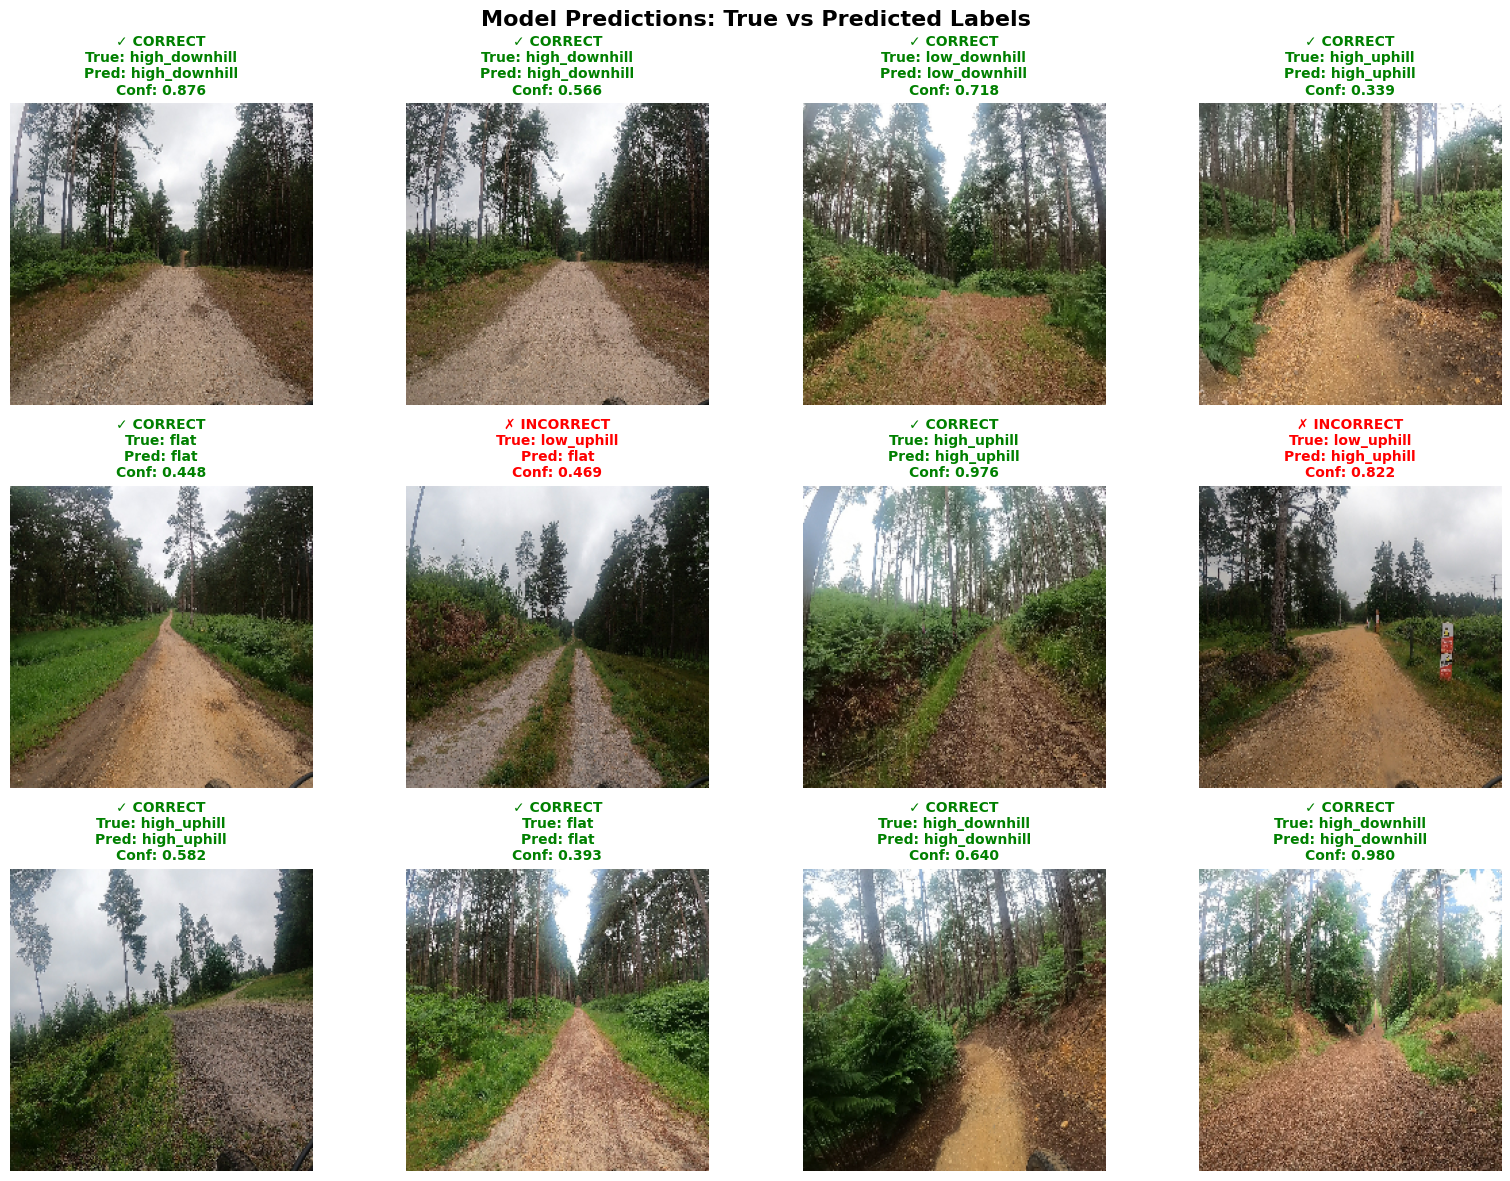


Sample Prediction Summary:
  • Correct predictions: 10/12
  • Sample accuracy: 0.833 (83.3%)
  • Average confidence: 0.651


In [ ]:
def visualize_model_predictions(model, val_ds, label_encoder, num_samples=12, output_dir=None):
    """
    Visualize model predictions on sample images with true vs predicted labels

    Args:
        model: Trained model
        val_ds: Validation dataset
        label_encoder: Label encoder for class names
        num_samples: Number of samples to visualize
        output_dir: Directory to save the visualization
    """
    print("Creating visual prediction analysis...")

    # Get a batch of images and labels
    sample_images = []
    sample_labels = []

    for images, labels in val_ds.take(1):
        sample_images = images[:num_samples]
        sample_labels = labels[:num_samples]
        break

    # Convert to numpy arrays for easier handling
    sample_images = sample_images.numpy()
    sample_labels = sample_labels.numpy()

    # Get model predictions
    predictions = model.predict(sample_images, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    prediction_confidences = np.max(predictions, axis=1)

    # Create visualization
    rows = 3
    cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(16, 12))
    fig.suptitle('Model Predictions: True vs Predicted Labels', fontsize=16, fontweight='bold')

    for i in range(num_samples):
        row = i // cols
        col = i % cols

        # Get true and predicted labels
        true_label = label_encoder.classes_[sample_labels[i]]
        pred_label = label_encoder.classes_[predicted_classes[i]]
        confidence = prediction_confidences[i]

        # Determine if prediction is correct
        is_correct = sample_labels[i] == predicted_classes[i]

        # Display image
        axes[row, col].imshow(sample_images[i])
        axes[row, col].axis('off')

        # Create title with true/predicted labels
        if is_correct:
            title_color = 'green'
            status = '✓ CORRECT'
        else:
            title_color = 'red'
            status = '✗ INCORRECT'

        title = f'{status}\nTrue: {true_label}\nPred: {pred_label}\nConf: {confidence:.3f}'
        axes[row, col].set_title(title, fontsize=10, color=title_color, fontweight='bold')

        # Add border color
        for spine in axes[row, col].spines.values():
            spine.set_edgecolor(title_color)
            spine.set_linewidth(3)

    plt.tight_layout()

    # Save if output directory provided
    if output_dir:
        save_path = os.path.join(output_dir, 'visual_predictions.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Visual predictions saved to: {save_path}")

    plt.show()

    # Print summary statistics - FIXED
    correct_predictions = np.sum(sample_labels == predicted_classes)  # Use np.sum instead
    accuracy = correct_predictions / num_samples

    print(f"\nSample Prediction Summary:")
    print(f"  • Correct predictions: {correct_predictions}/{num_samples}")
    print(f"  • Sample accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")
    print(f"  • Average confidence: {np.mean(prediction_confidences):.3f}")

# Run visual prediction analysis - FIXED variable reference
visualize_model_predictions(model, val_ds, label_encoder, num_samples=12, output_dir=CONFIG['OUTPUT_DIR'])